# Kenya cereals crop model using Gro API
A simple crop model using data in Gro for five crops (Corn, Wheat, Barley, Sorghum and Millet). The accompanying Gro web app display for [ET-KE-SO Cereals](https://app.gro-intelligence.com/displays/wZRlaQb9B) provides an overview of the data series we will use. The goal is to have a robust model that can be used on day of the year to forecast end of year yield.

## Preliminary

In [142]:
import logging
import os
import warnings
from api.client.crop_model import CropModel
    
warnings.filterwarnings('ignore')

countries = ["Kenya"]
crops = ["Corn", "Wheat", "Barley", "Sorghum", "Millet"]
model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

##  Historical yields
To get data series for national level yields, we set the entities (item, metric and region), and 
find available data series.  Note that there are  a few different <em>sources</em>, e.g. 
[FAO](https://app.gro-intelligence.com/dictionary/sources/2), 
[PS&D](https://app.gro-intelligence.com/dictionary/sources/14), 
[IGC](https://app.gro-intelligence.com/dictionary/sources/19).  Each source covers a slightly different time range. Note that one source, PS&D, uses market-years that go from July to June, while the other two use calendar years. All differ from each other to some extend in the reported yields.  Let us examine them to decide which to use as "ground truth" training data. 

In [143]:
TONNES_PER_HECTARE_UNIT_ID = 61

for country in countries:
    for crop in crops:
        for yield_series in model.find_data_series(region=country, item=crop, metric="yield mass/area"):
            yield_series['unit_id'] = TONNES_PER_HECTARE_UNIT_ID
            model.add_single_data_series(yield_series)

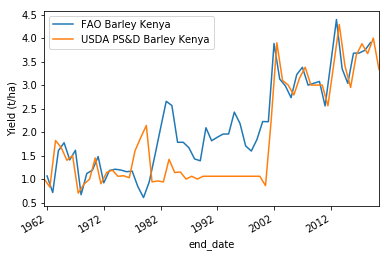

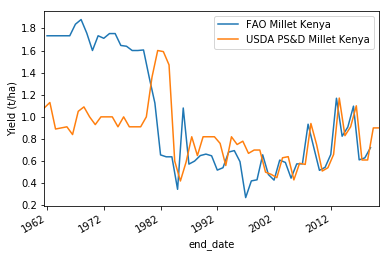

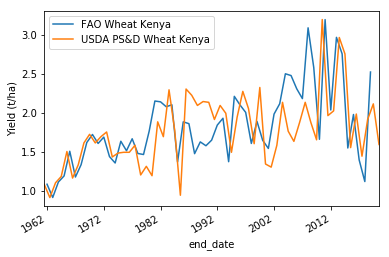

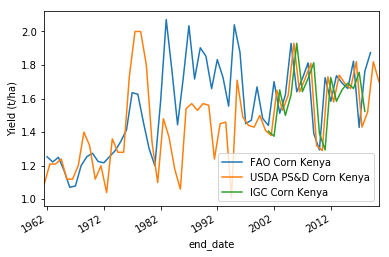

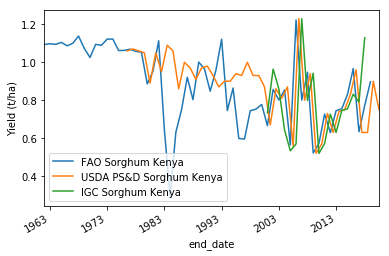

In [144]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

df = model.get_df()
yield_metric_id = model.search_for_entity("metrics", "yield mass/area")

for item_id, yield_df in df.loc[df.metric_id == yield_metric_id].groupby(['item_id']):
    fig, axes = plt.subplots(1, 1)
    for (source_id, region_id), group in yield_df.groupby(['source_id', 'region_id']):
        group.plot(x='end_date', y='value', ax=axes, x_compat=True,
                   label="{} {} {}".format(model.lookup('sources', source_id)['name'], 
                                           model.lookup('items', item_id)['name'],
                                           model.lookup('regions', region_id)['name']))
    plt.ylabel("Yield (t/ha)")
    plt.show()

FAO includes two seasons that are in the same calendar year. PS&D reports the same information but shifted by 6 months. While IGC reports it shifted by a year. To avoid discrepancies in reporting time frames as we line up geospatial information with historical yields, we select one source [FAO](https://app.gro-intelligence.com/dictionary/sources/2).

##  Detrend yields

We decouple our modeling efforst into long term trends and seasonal variations. First, we compute the yield trends over the last 35 years, which gives us our long term model. The de-trended yield will be our target for in-season modeling.

Barley


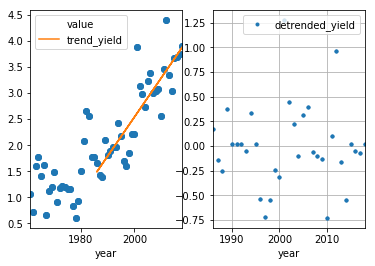

Millet


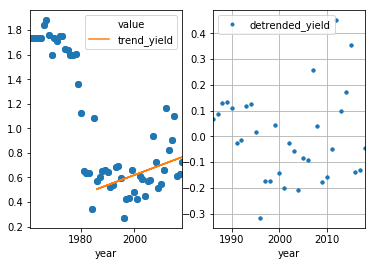

Wheat


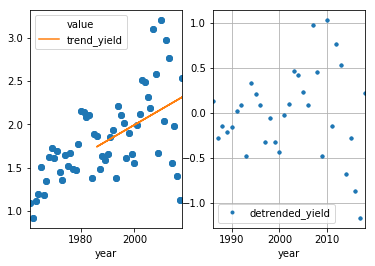

Corn


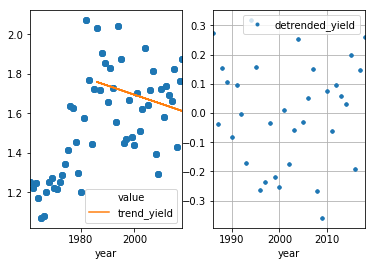

Sorghum


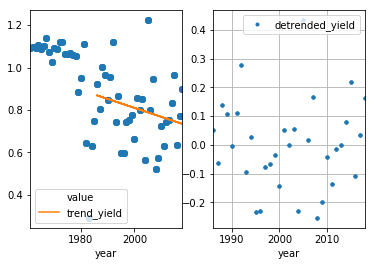

In [145]:
from sklearn import linear_model

TREND_START_YEAR = 1985
df = model.get_df()
dy_df = {}
trends = {}

for item_id, XY in df.loc[(df.metric_id == yield_metric_id) & (df.source_id == 2) ].groupby(['item_id']):
    crop = model.lookup('items', item_id)['name']
    print(crop)
    # Compute trend
    trend = linear_model.LinearRegression()
    XY['year'] = XY.end_date.map(lambda x: x.year)
    X = XY.loc[XY.year > TREND_START_YEAR].loc[:, ['year']]
    Y = XY.loc[XY.year > TREND_START_YEAR]['value']
    trend.fit(X, Y)
    trends[crop] = trend
    lm_df = pandas.DataFrame([{'year': year, 'trend_yield': value}
                             for (year, value) in zip(X['year'], trend.predict(X))])
    # De-trend
    dy = pandas.DataFrame([{'year': year, 'detrended_yield': value}
                             for (year, value) in zip(
                                XY.loc[XY.year > TREND_START_YEAR]['year'], 
                                XY.loc[XY.year > TREND_START_YEAR].apply(lambda row: row.value - trend.predict([[row.year]])[0], axis=1))
                                                      ])
    dy_df[crop] = dy
    
    # Plot
    fig, axes = plt.subplots(1, 2)
    XY.plot(x='year', y='value', marker='o', linestyle='', ax=axes[0])
    lm_df.plot(x='year', y='trend_yield',  ax=axes[0])
    dy.plot(x='year', y='detrended_yield', marker='.', linestyle='', ax=axes[1])
    plt.grid(b=True, which='both')
    plt.show()

## Per crop land cover area as  "weight" 
We compute the "weight" of each region, based on the land area covered by each of the different cereals. 

Note that in Kenya, while the yield data is for [Millet](https://app.gro-intelligence.com/dictionary/items/21), the land cover data actually consists of two different varieties: mostly [Pearl millet](https://app.gro-intelligence.com/dictionary/items/416) with a little bit of [Small millet](https://app.gro-intelligence.com/dictionary/items/7471). They tend to grow in very distincts part of the country as shown in [this Gro display](https://app.gro-intelligence.com/displays/4LRy1byR3). We will use both for land cover and combine them into a weight for Millet as a whole.

First we get the regions.

In [146]:
REGION_LEVEL_ID = 5
regions = []

for country in countries:
    country_id = model.search_for_entity('regions', country)
    for region in model.get_descendant_regions(country_id, REGION_LEVEL_ID):    
        regions.append(region)

region_ids = [region['id'] for region in regions]
print("{} regions".format(len(regions)))

338 regions


Then we inspect their weights. This step can be skipped as we will automatically recompute the weights when using them.

In [161]:
import numpy
import logging

weights = {}

for crop in crops:
    print(crop)
    w = model.compute_weights(crop, "land cover area", regions)
    if not w:
        continue
    weights[crop] = pandas.DataFrame([{'region': region['name'], 'weight': wr} for (region, wr) in zip(regions, w)])
    print(weights[crop])

Corn
               region        weight
0              Kiambu           NaN
1           Kirinyaga           NaN
2            Machakos           NaN
3            Murang'a           NaN
4           Nyandarua           NaN
5               Nyeri           NaN
6              Kilifi           NaN
7               Kwale           NaN
8                Lamu           NaN
9             Mombasa           NaN
10       Taita Taveta           NaN
11         Tana River           NaN
12               Embu           NaN
13             Isiolo           NaN
14              Kitui           NaN
15           Machakos           NaN
16            Makueni           NaN
17           Marsabit           NaN
18               Meru           NaN
19              Nithi           NaN
20              Wajir           NaN
21            Nairobi           NaN
22            Garissa           NaN
23            Mandera           NaN
24              Wajir           NaN
25           Homa Bay           NaN
26              Kisii  

               region    weight
0              Kiambu       NaN
1           Kirinyaga       NaN
2            Machakos       NaN
3            Murang'a       NaN
4           Nyandarua       NaN
5               Nyeri       NaN
6              Kilifi       NaN
7               Kwale       NaN
8                Lamu       NaN
9             Mombasa       NaN
10       Taita Taveta       NaN
11         Tana River       NaN
12               Embu       NaN
13             Isiolo       NaN
14              Kitui       NaN
15           Machakos       NaN
16            Makueni       NaN
17           Marsabit       NaN
18               Meru       NaN
19              Nithi       NaN
20              Wajir       NaN
21            Nairobi       NaN
22            Garissa       NaN
23            Mandera       NaN
24              Wajir       NaN
25           Homa Bay       NaN
26              Kisii       NaN
27             Kisumu       NaN
28             Migori       NaN
29            Nyamira       NaN
..      

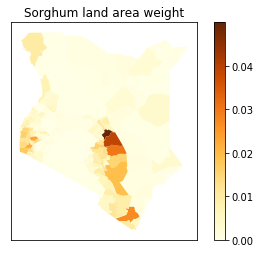

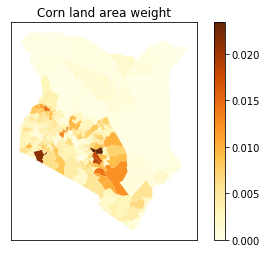

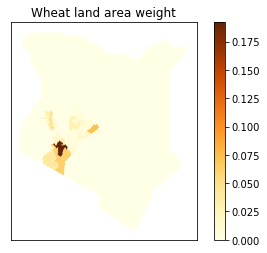

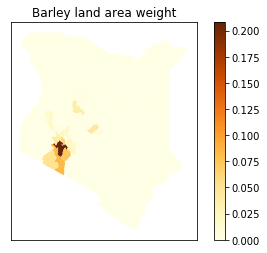

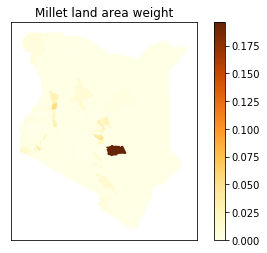

In [154]:
import geopandas
from shapely.geometry import shape

for crop in weights:
    shapes = []
    for (region, weight) in zip(regions, weights[crop].weight):
        geojson = model.get_geojson(region['id'])
        if not geojson:
            continue
        shapes.append(
            { 'region_id': region['id'], 
              'geometry': shape(geojson['geometries'][0]),
              'crop_weight': weight if weight > 0 else 0
            }) 
    gdf = geopandas.GeoDataFrame(shapes)
    gdf.set_index('region_id')
    fig, axes = plt.subplots(1, 1)
    gdf.plot(column='crop_weight', 
         cmap='YlOrBr', ax=axes, vmin=0, vmax=weights[crop].weight.max(), legend=True)
    axes.set_title('{} land area weight'.format(crop))
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plt.show()

## NDVI

In [ ]:
cw_ndvi_dfs = {}

for crop in crops:
    print(crop)
    cw_ndvi_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Vegetation NDVI', 'Vegetation Indices', regions)

In [30]:
def show_series(fdf, item_name, metric_name, 
                 eval_start_date, cmap='Greens', vmin=None, vmax=None):
    """Plot choropleth map of the series on the given date, and time series for each region."""
    item_id = model.search_for_entity("items", item_name)
    metric_id = model.search_for_entity("metrics", metric_name)
    print(item_id, metric_id)
    df1 = fdf.loc[(fdf.item_id == item_id) & (fdf.metric_id == metric_id) & (fdf.start_date == eval_start_date),:]
    gdf1 = gdf.join(df1.set_index('region_id'), on='region_id')
    fig, axes = plt.subplots(1, 1)
    gdf1.plot(column='value', cmap=cmap, ax=axes, vmin=vmin, vmax=vmax, legend=True)
    axes.set_title('{} {}'.format(item_name, metric_name))
    fig, axes = plt.subplots(1, 1, figsize=(12,8))
    for region_id, group in fdf.loc[
        (fdf.item_id == item_id) & (fdf.metric_id == metric_id)].groupby(['region_id']):
        if not group['value'].dropna().size:
            continue
        group.plot(x='end_date', y='value', ax=axes, legend=False) # label=model.lookup('regions', region_id)['name'])
        plt.grid(b=True, which='both')
    plt.show()

Corn
(321, 70029)


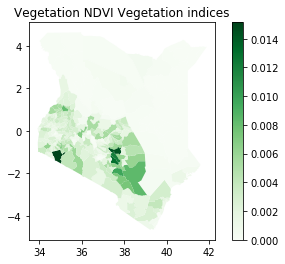

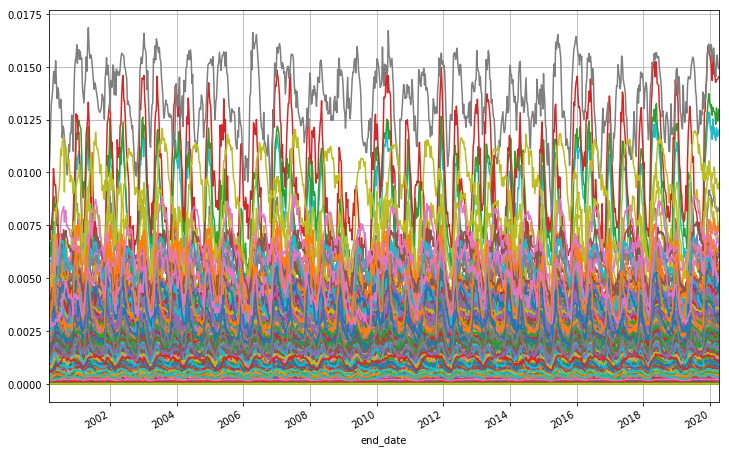

Wheat
(321, 70029)


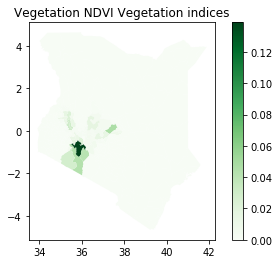

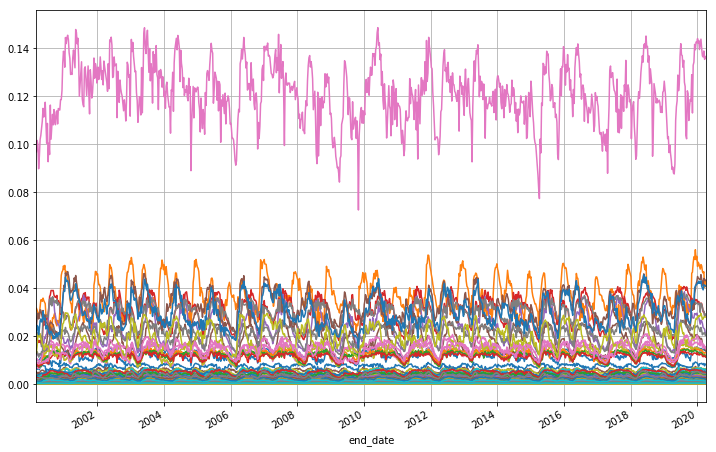

Barley
(321, 70029)


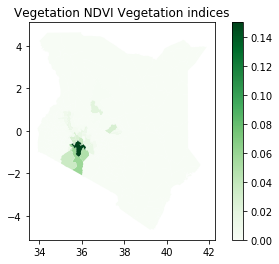

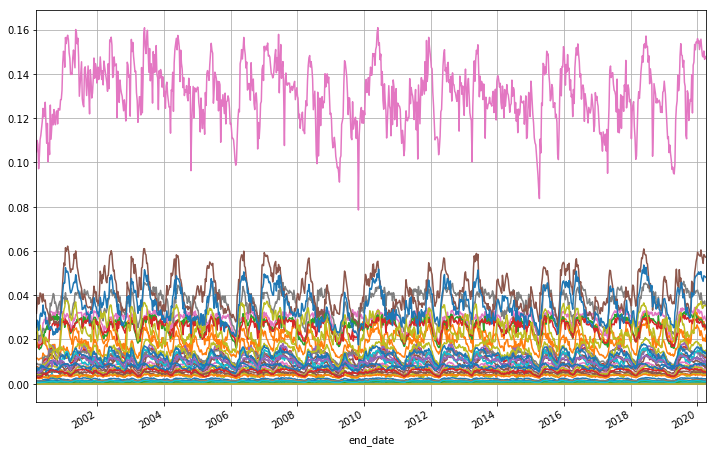

Sorghum
(321, 70029)


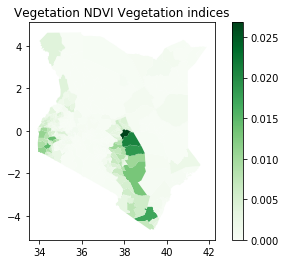

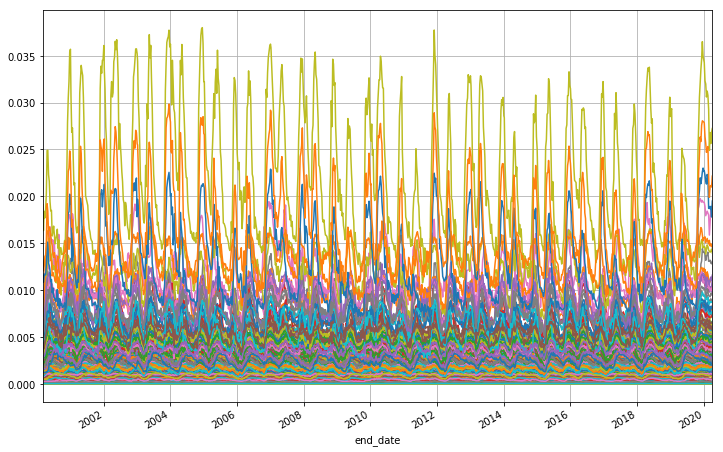

Millet
(321, 70029)


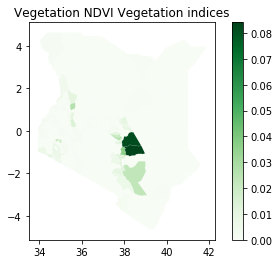

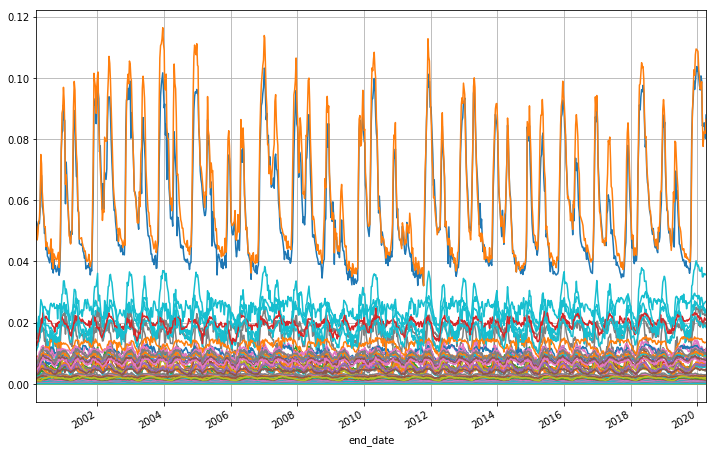

In [31]:
for crop in crops:
    print(crop)
    show_series(cw_ndvi_dfs[crop], "Vegetation NDVI", "Vegetation indices", u'2020-03-05', 'Greens')

## Evapotranspiration

In [ ]:
cw_et_dfs = {}

for crop in crops:
    print(crop)
    cw_et_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Evapotranspiration', 'Evapotranspiration value', regions)

In [ ]:
for crop in crops:
    print(crop)
    show_series(cw_et_dfs[crop], "Evapotranspiration", "Evapotranspiration value", '2020-02-01', 'Blues')

## ET anomaly
Now let's look at [evapotranspiration](https://app.gro-intelligence.com/dictionary/items/4395) [anomaly](https://app.gro-intelligence.com/dictionary/metrics/15852239).

In [156]:
cw_eta_dfs = {}

for crop in crops:
    print(crop)
    cw_eta_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Evapotranspiration', 'Evapotranspiration difference from 10-yr median (2003-2013)',
        regions, lambda w,v: w*(v-100.0))

Corn
Wheat
Barley
Sorghum
Millet


Examine on a particular date, first ET anomaly and then ET anomaly normalized and weigthed by crop land.

Corn
(4395, 15852239)


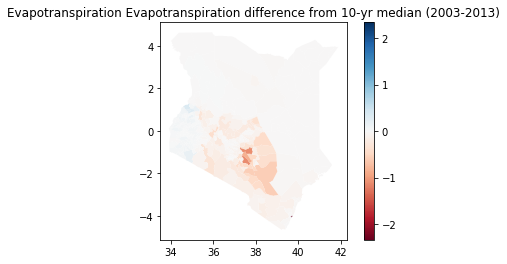

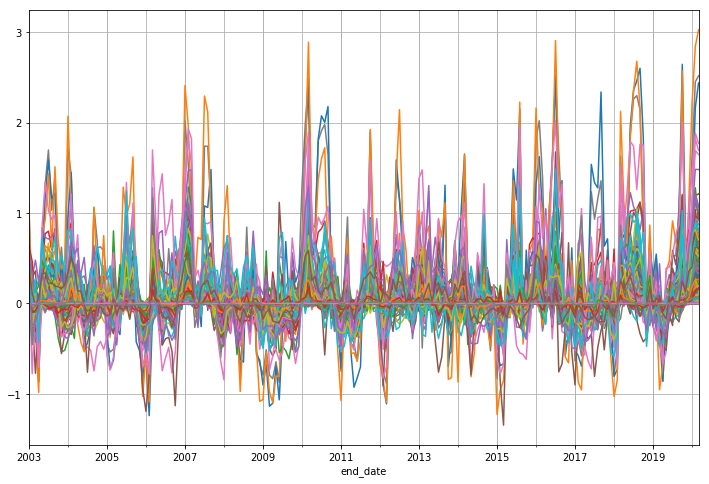

Wheat
(4395, 15852239)


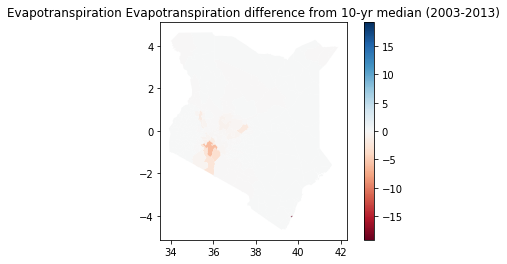

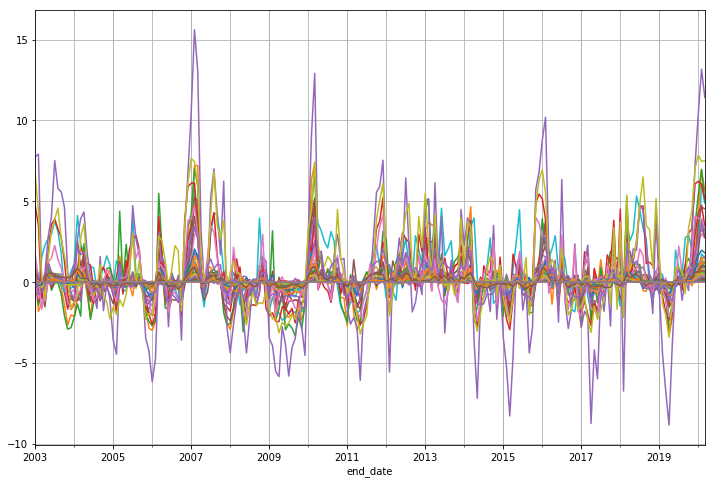

Barley
(4395, 15852239)


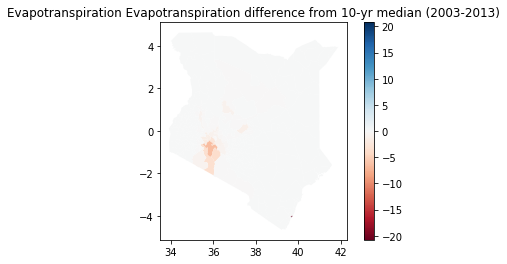

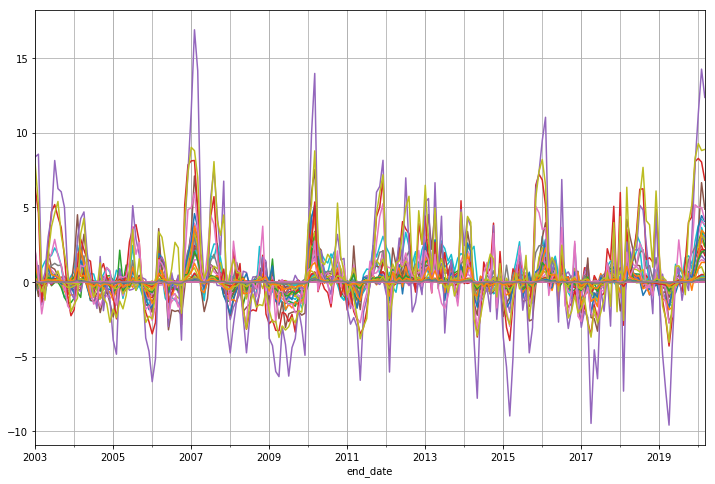

Sorghum
(4395, 15852239)


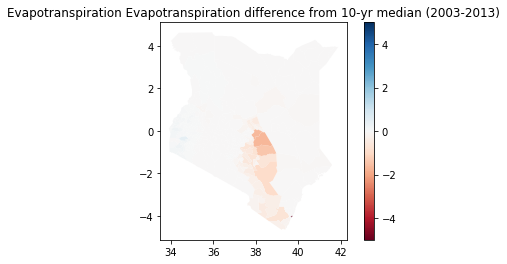

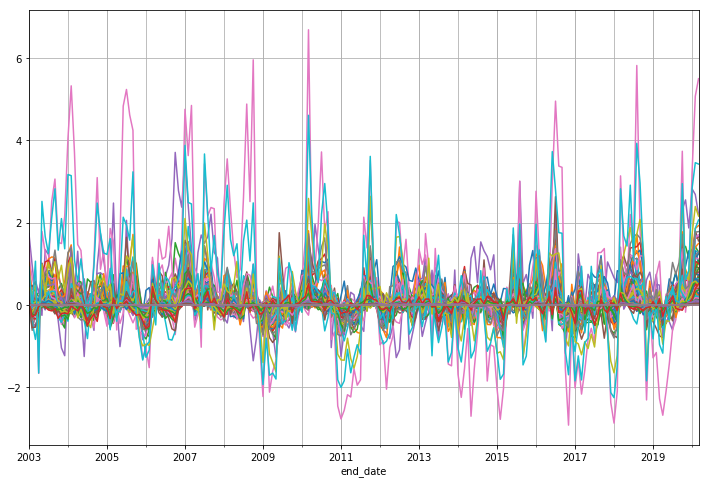

Millet
(4395, 15852239)


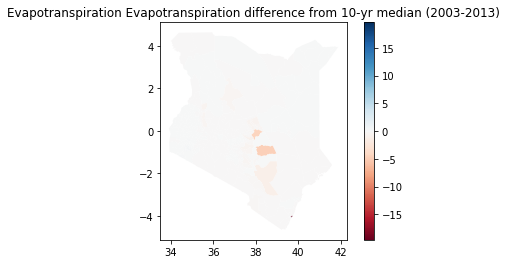

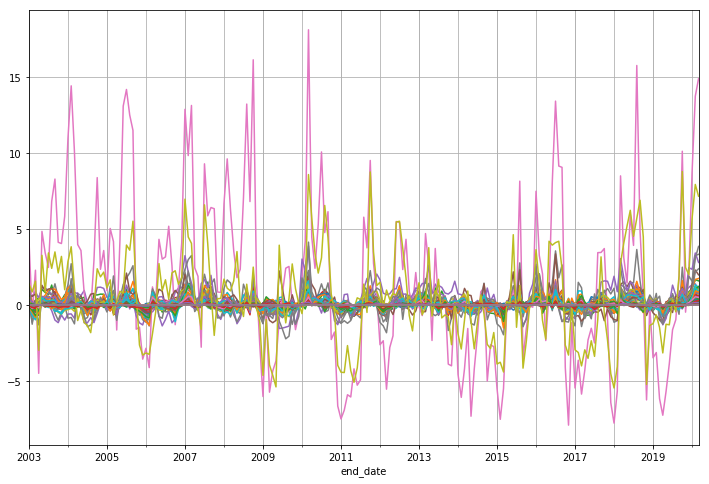

In [157]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_eta_dfs[crop], 
                 "Evapotranspiration", 
                 "Evapotranspiration difference from 10-yr median (2003-2013)", 
                 '2009-04-01', 'RdBu',vmin=-100*amp, vmax=100.0*amp)

## Rainfall

In [158]:
cw_rf_dfs = {}

for crop in crops:
    print(crop)
    cw_rf_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Rainfall', 'Precipitation difference from 10-yr mean (2001-2010)',
        regions)

Corn
Wheat
Barley
Sorghum
Millet


Corn
(2039, 2110131)


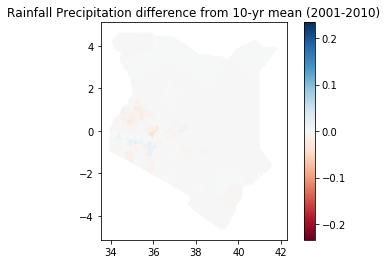

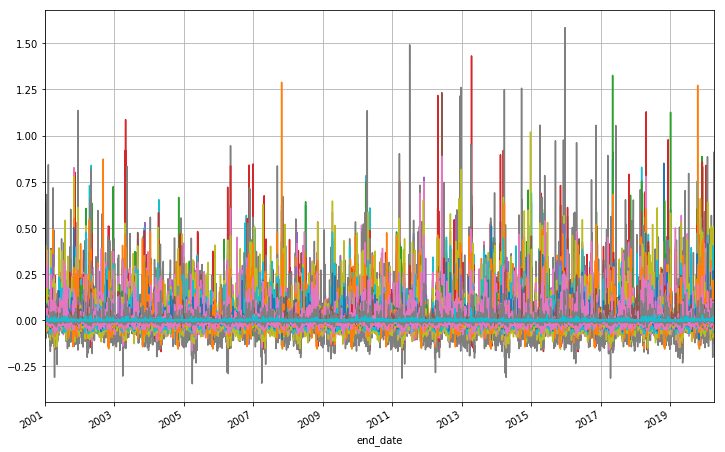

Wheat
(2039, 2110131)


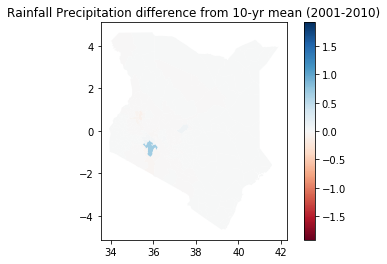

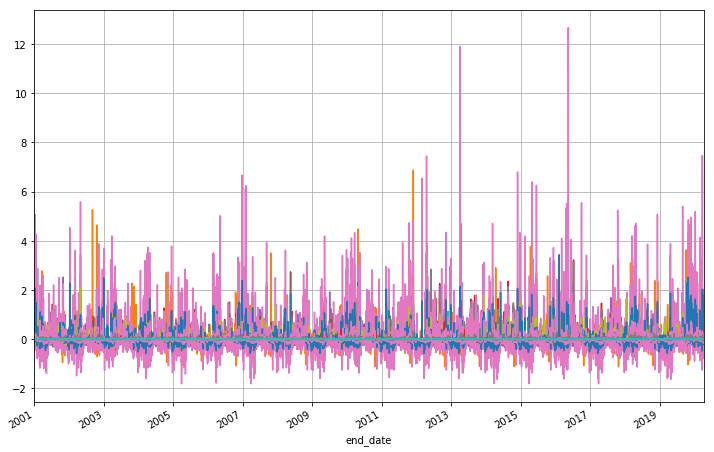

Barley
(2039, 2110131)


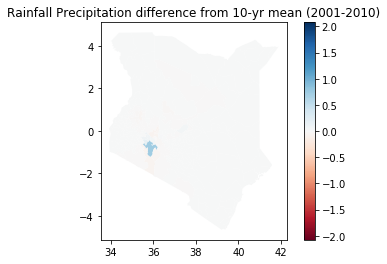

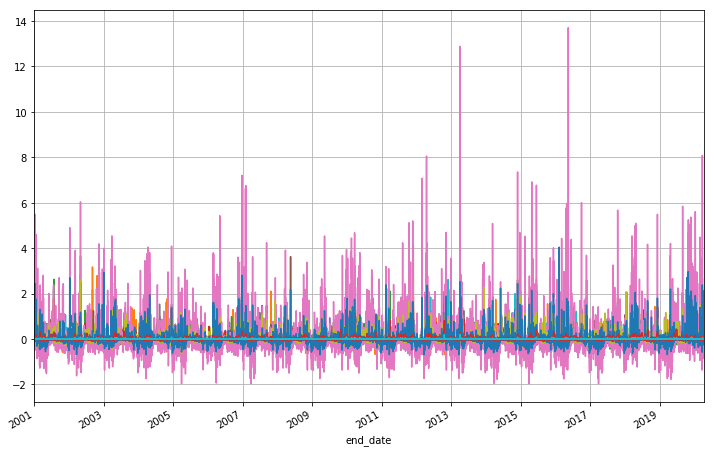

Sorghum
(2039, 2110131)


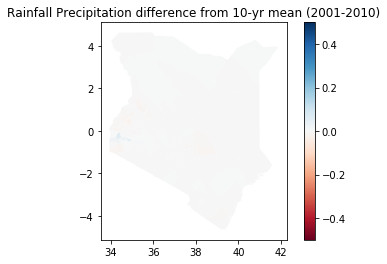

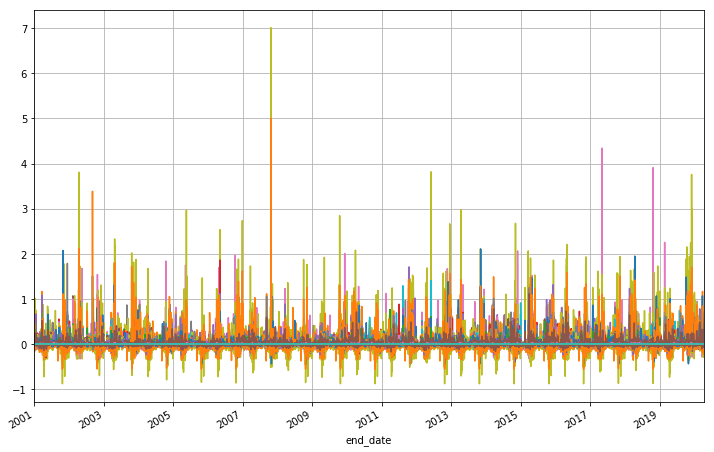

Millet
(2039, 2110131)


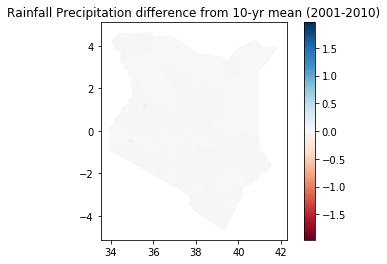

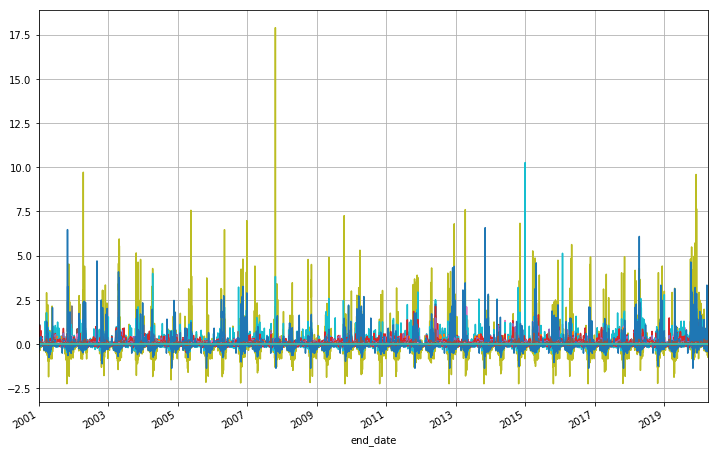

In [159]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_rf_dfs[crop], 
                 "Rainfall", 
                 "Precipitation difference from 10-yr mean (2001-2010)",
                 '2019-07-01', cmap='RdBu',vmin=-10*amp, vmax=10.0*amp)

## Temperature

In [ ]:
cw_temp_dfs = {}

for crop in crops:
    print(crop)
    cw_temp_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Land temperature daytime', 'Temperature',
        regions)

Corn
(3457, 2540047)


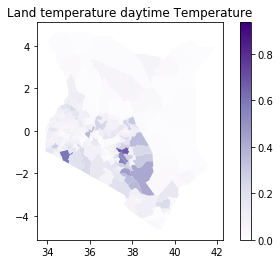

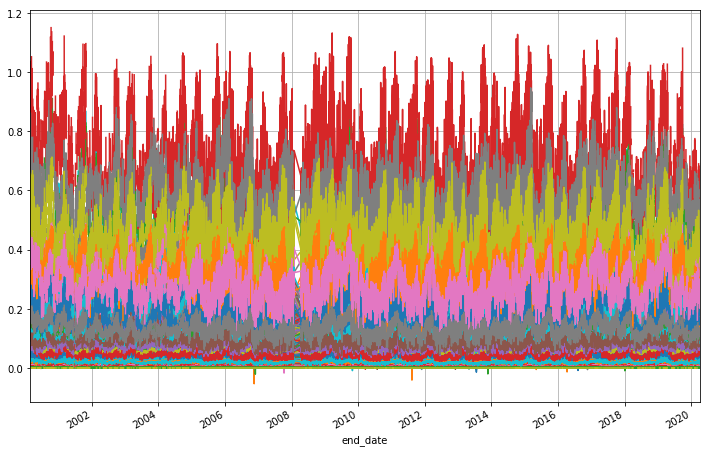

Wheat
(3457, 2540047)


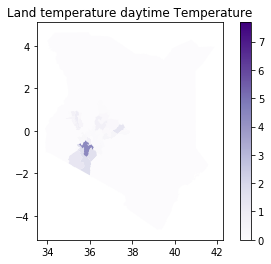

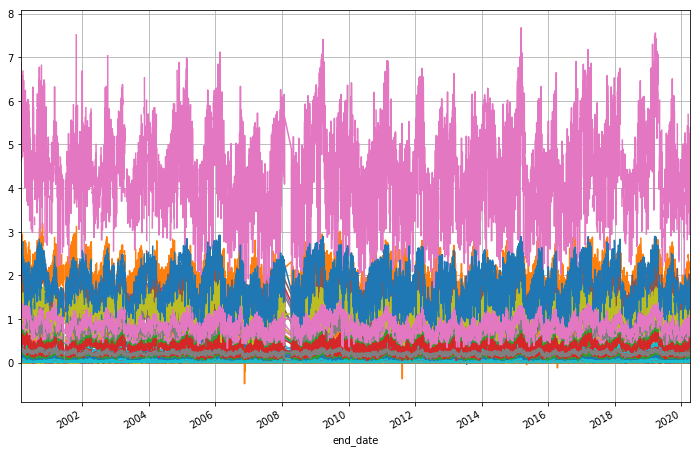

Barley
(3457, 2540047)


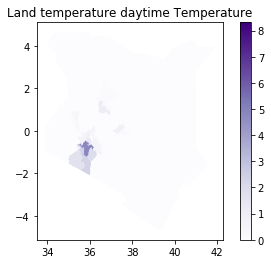

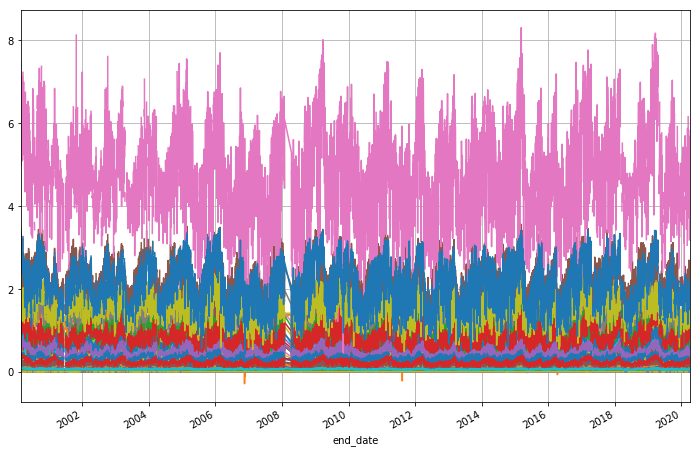

Sorghum
(3457, 2540047)


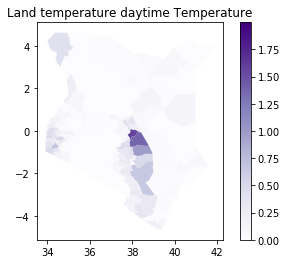

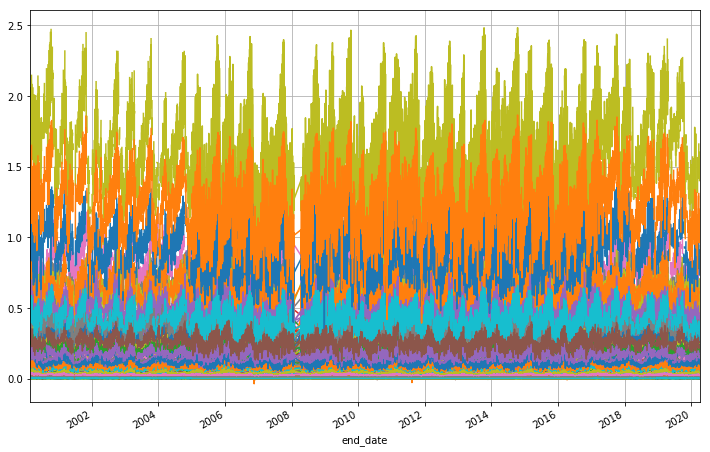

Millet
(3457, 2540047)


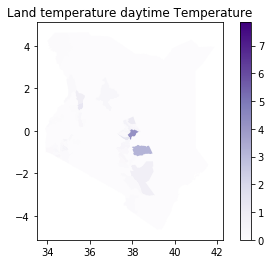

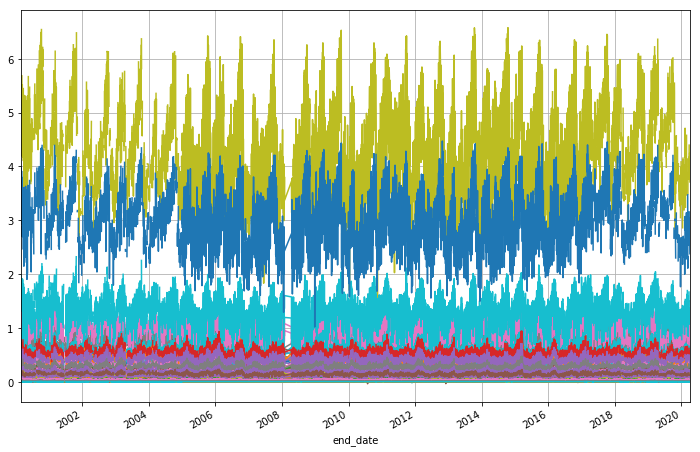

In [160]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_temp_dfs[crop], 
                "Land temperature daytime", 
                "Temperature",
                '2010-07-01',cmap='Purples', vmin=0, vmax=amp*40)

## Relationship between  yield and crop-weighted geospatial feature
In specific parts of the season, we can look at crop weighted geospatial data as predictor of yield for the year. Using our [display](https://app.gro-intelligence.com/displays/wZRlaQb9B), based on crop calendar information, we look at historical values of the feature during such selected phases of the season, and compare them to the final yields for the same year.

In [119]:
import numpy

def peak_day(g):
    try:
        index = numpy.nanargmax(g.value)
        v = g.iloc[index].end_date.dayofyear
        return v
    except ValueError:
        return numpy.nan

def avg_td(df):
    return df.value.mean()


def get_feature(cw_df, feature_name, doy, start_doy=None, tol=0, func=avg_td, year=None):
    """A 'feature' is the data series grouped by region, evaluated from start_doy to doy, 
    in each year. func is the evaluation function (average, peak, etc.).
    """
    if not start_doy:
        start_doy = doy
    if year:
        cw_df = cw_df.loc[cw_df.end_date.map(lambda x: x.year == year)]
    if start_doy > doy:
        return pandas.DataFrame()

    print('{}, {}-{}'.format(feature_name, start_doy, doy))
    features = []
    
    for region_id, group in cw_df.groupby('region_id'):
            
            def window_in_year(row):
                # apply func() on data from start_doy to row.end_date
                return func(group.loc[group.end_date.map(
                    lambda x: x.year == row.end_date.year \
                              and x.dayofyear >= start_doy \
                              and x.dayofyear <= row.end_date.dayofyear)
                                ])

            tmp = group.loc[group.end_date.map(lambda x: x.dayofyear<=doy and x.dayofyear>=doy-tol),:]
            tmp.loc[:, 'value'] = tmp.apply(window_in_year, axis=1)
            features.append(tmp)

    feature_df = pandas.concat(features)
    # group by date and sum regions
    return pandas.DataFrame([{'year': end_date.year, feature_name: float(group.value.sum())}
                              for (end_date, group) in  feature_df.groupby(['end_date'])])


def show_feature(x_df, y_df, feature_name):
    """Time series and scatter plot of feature and yield"""
    xy_df = x_df.merge(y_df, on='year', how='outer')
    figs, axes = plt.subplots(1, 3, figsize=(12, 8))
    xy_df.plot(x='year', y=feature_name, marker= 'o', ax=axes[1])
    xy_df.plot(x='year', y='detrended_yield', marker= '.', linestyle='None',ax=axes[0])
    plt.grid(b=True, which='both')
    xy_df.plot.scatter(x=feature_name, y = 'detrended_yield',ax=axes[2])
    plt.grid(b=True, which='both')
    plt.show()

### ET anomaly jun-sep

Corn
Evapotranspiration, 180-275


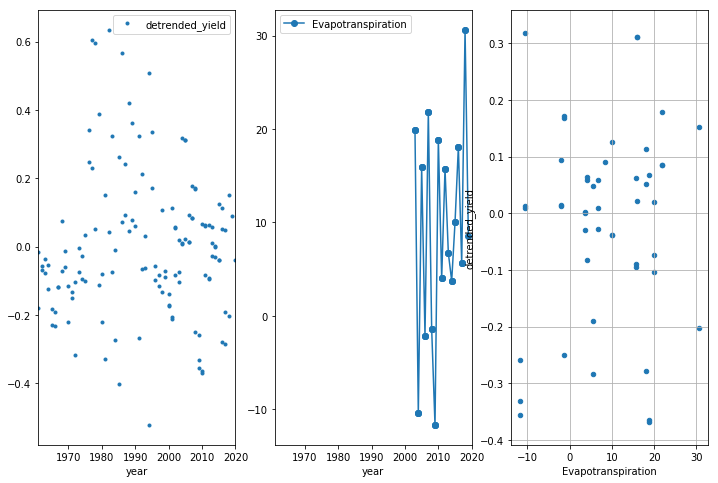

Wheat
Evapotranspiration, 180-275


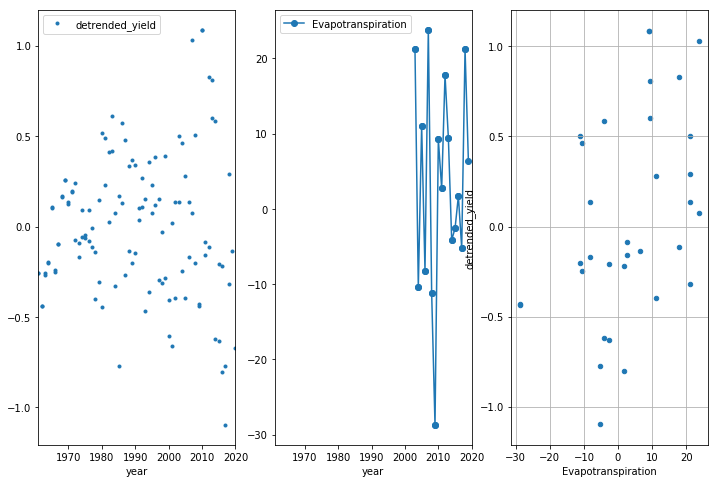

Barley
Evapotranspiration, 180-275


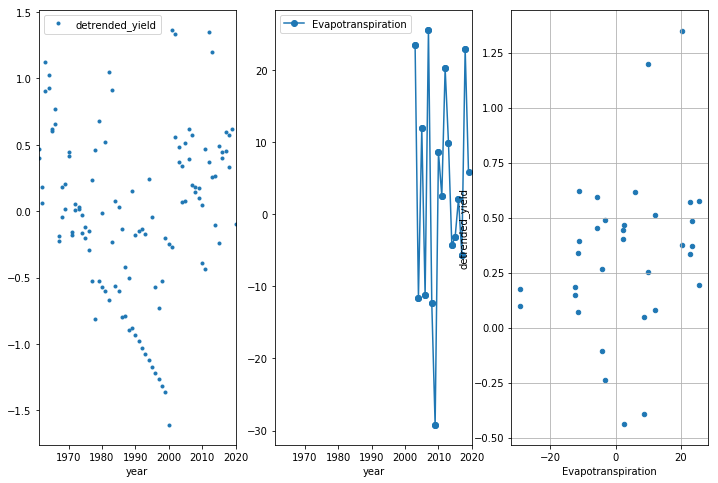

Sorghum
Evapotranspiration, 180-275


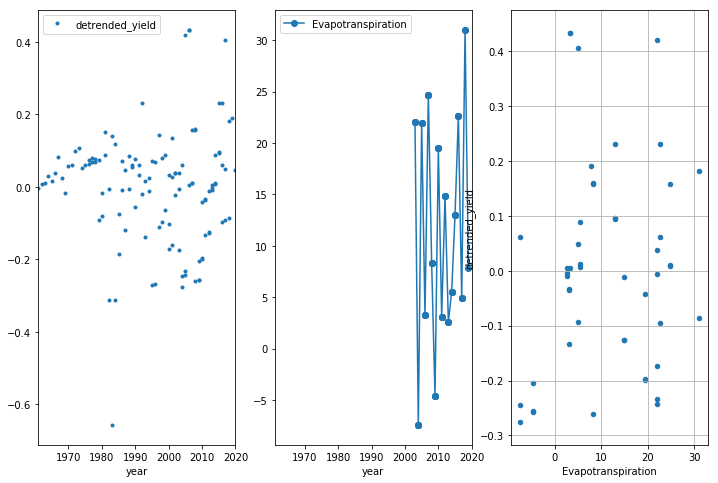

Millet
Evapotranspiration, 180-275


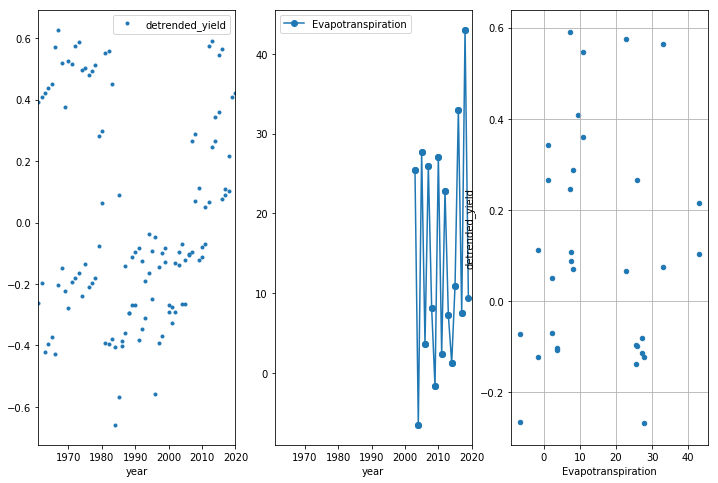

In [37]:
for crop in crops:
    print(crop)
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        continue
    feat = get_feature(cw_eta_dfs[crop], 
                       "Evapotranspiration", 275,180,tol=10)
    show_feature(feat, y_df, "Evapotranspiration")

### NDVI
For NDVI, rather than the average or most recent value, the date of it's peak is found to be the strongest feature. The idea is that the relatively early or late occurence of  planting and growth is highly connected to conditions that ultimately affect yield. See e.g. [this paper](https://link.springer.com/article/10.1007/s10584-019-02432-7) which discuses such effects in 2015 in Ethiopia.

For example, let's look at how the timing of the peak of crop-weigthed NDVI between May and September relates to yield. 

Corn
Corn_ndvi, 135-273


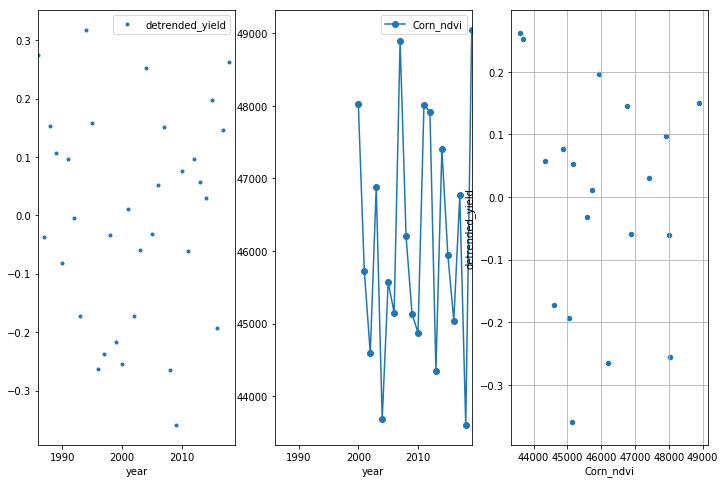

Wheat
Wheat_ndvi, 135-273


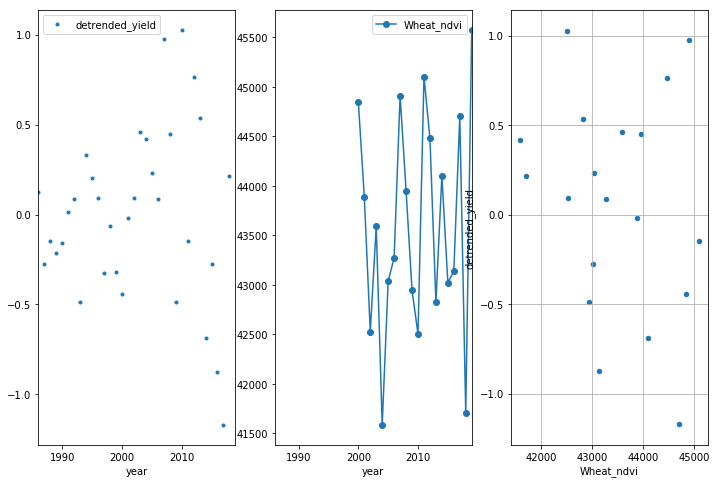

Barley
Barley_ndvi, 135-273


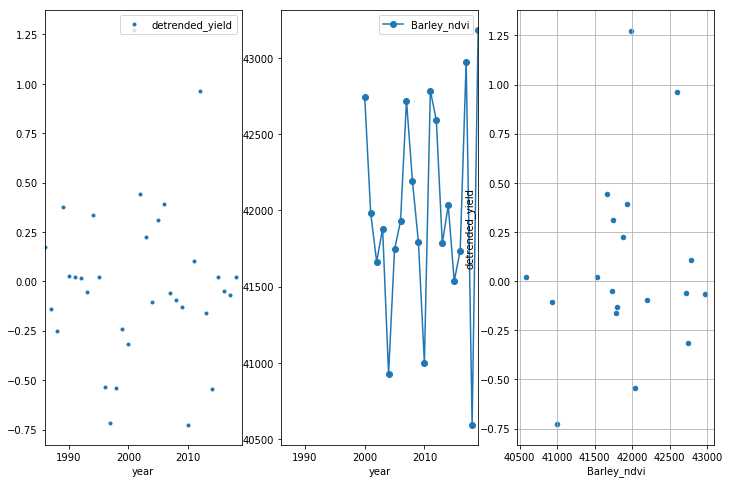

Sorghum
Sorghum_ndvi, 135-273


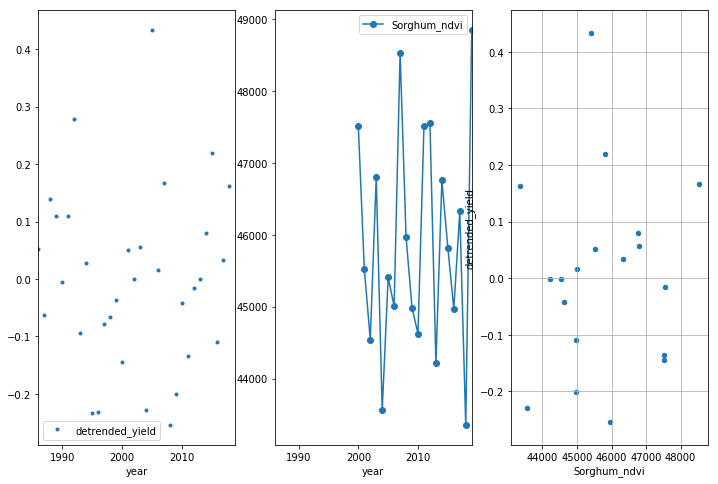

Millet
Millet_ndvi, 135-273


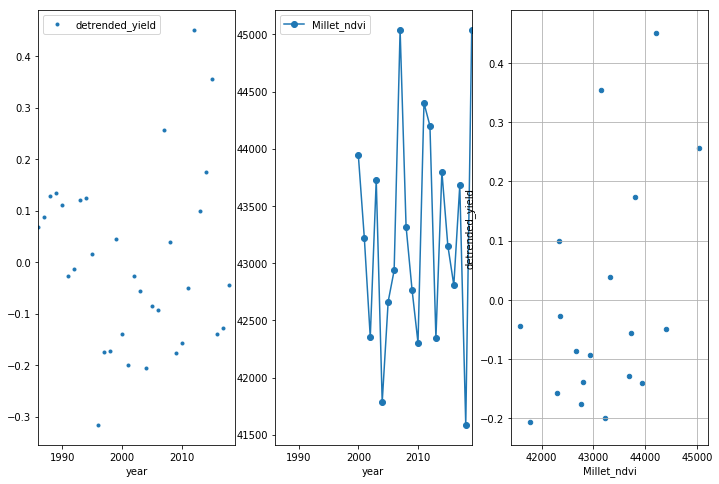

In [97]:
for crop in crops:
    print(crop)
    feature = get_feature(cw_ndvi_dfs[crop],  "{}_ndvi".format(crop), 
                          doy=273, start_doy=135, tol=6, func=peak_day)
    show_feature(feature, dy_df[crop], "{}_ndvi".format(crop))

### Rainfall anomaly may-jul

Corn_rain, 120-210


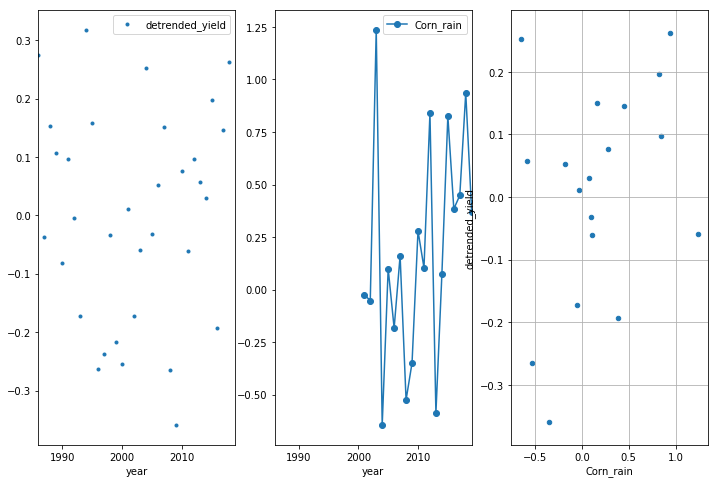

Wheat_rain, 120-210


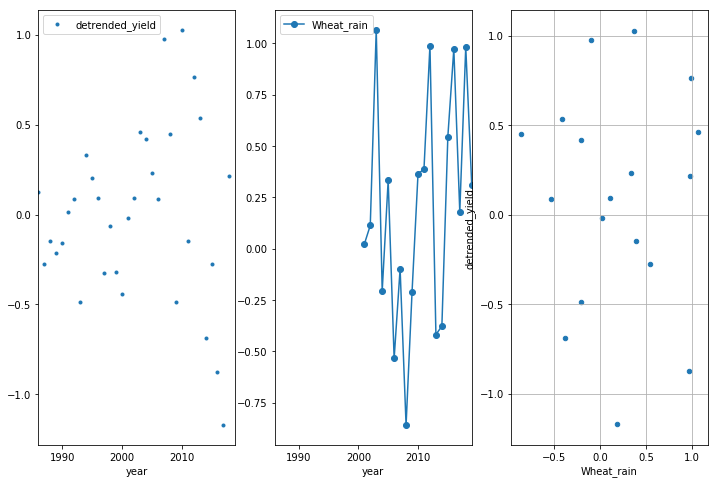

Barley_rain, 120-210


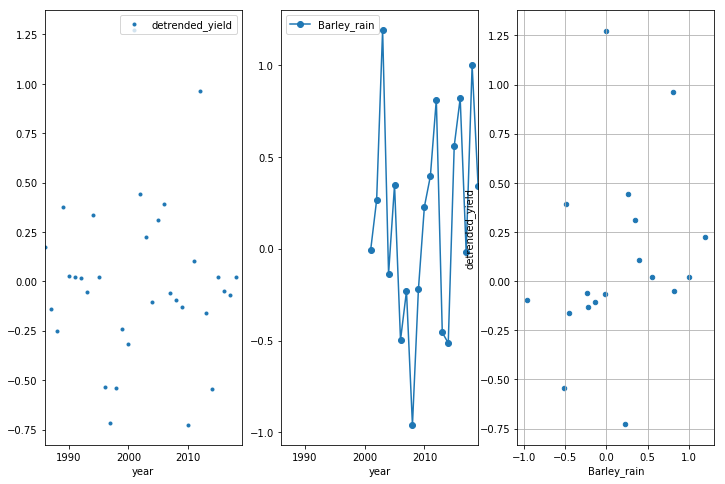

Sorghum_rain, 120-210


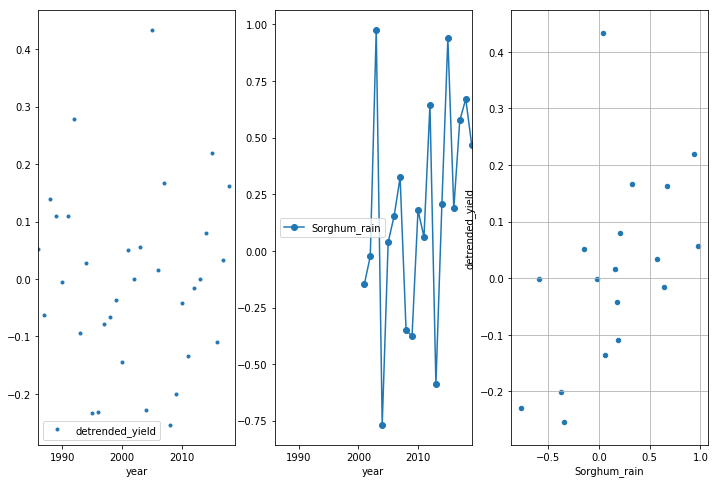

Millet_rain, 120-210


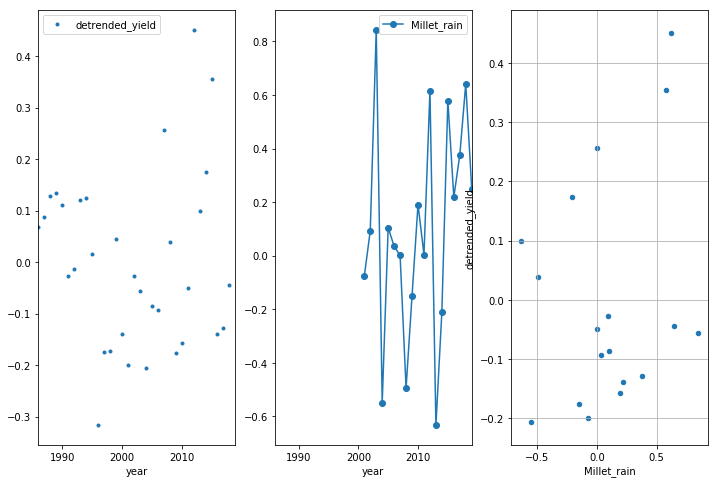

In [121]:
for crop in crops:
    feat = get_feature(cw_rf_dfs[crop], "{}_rain".format(crop), doy=210, start_doy=120)
    show_feature(feat, dy_df[crop], "{}_rain".format(crop))

### Temperature jan-mar

Corn_temp, 1-93


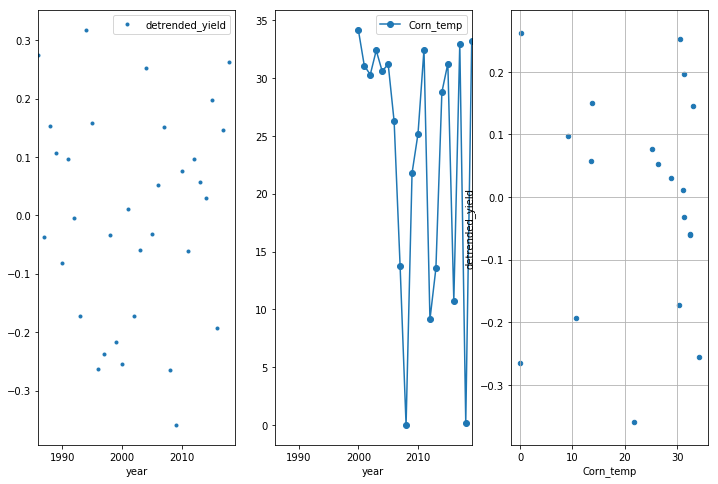

Wheat_temp, 1-93


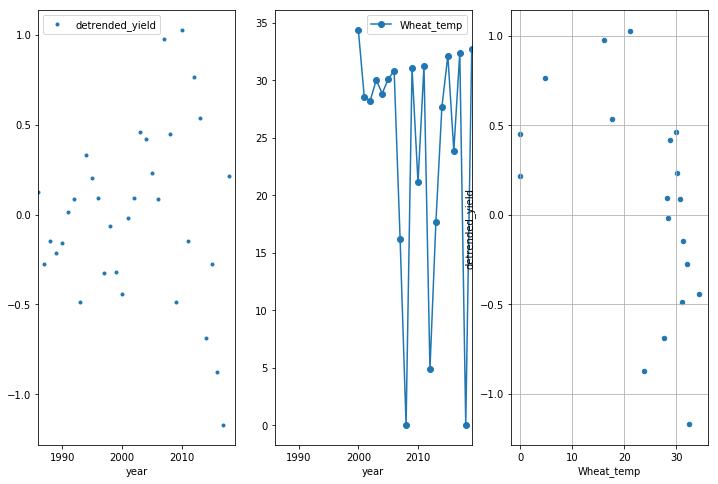

Barley_temp, 1-93


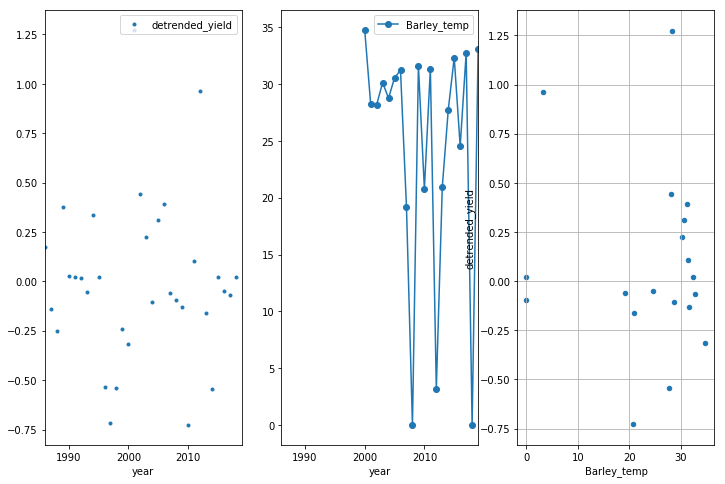

Sorghum_temp, 1-93


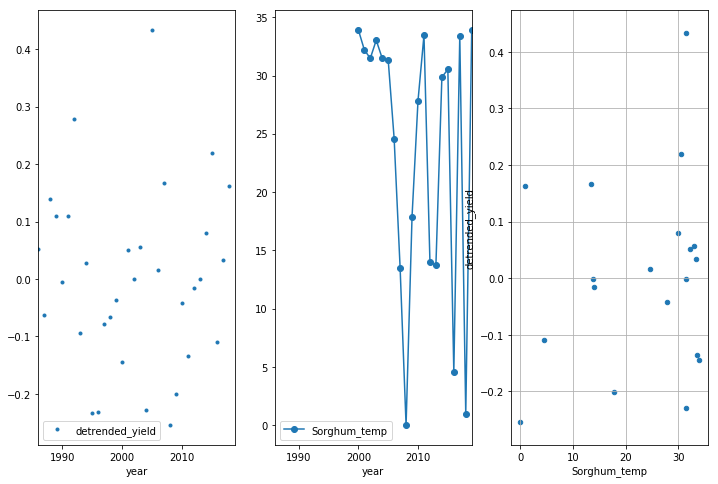

Millet_temp, 1-93


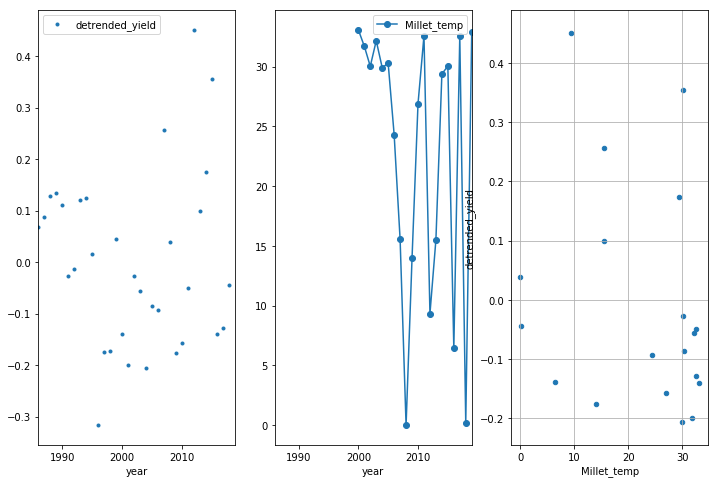

In [124]:
for crop in crops:
    f_df = get_feature(cw_temp_dfs[crop], "{}_temp".format(crop), doy=93,start_doy=1)
    show_feature(f_df, dy_df[crop], "{}_temp".format(crop))

## In-season yield model

We now fit a yield model to the above crop weighted features. The approach will give us a forecast for current year yields throughout the year. But we'll focus on a few key moments: end of March, end of June and end of Sept.

In order to select features for the model we will use the fact that in Kenya there are two seasons: May-Sep and  Dec-Feb as we can see from the crop calendars.

In [140]:
import IPython
iframe="<iframe dropshadow=0 allowinteraction frameborder=0 width='640' height='600' src='https://app.gro-intelligence.com/#/embed/A3dWyBWRD?chartId=aWQ9MzE4MzMyJnRpdGxlPXRydWUmbG9nbz10cnVlJmRpc3BsYXl0aXRsZT1LZW55YSBjZXJlYWxz'></iframe>"
IPython.display.HTML(iframe)

In [44]:
# First crop end of april to end of sep
START_1=112
END_1=273
# Second crop Dec-Feb
START_2=1
END_2=60

lms_by_doy = {}

### Model training

Using features available as of day-of-year 100, 182, 273.

In [69]:
def show_results(lm_tuple, y_df=None):
    fig, axes = plt.subplots(1, 1)
    lm_tuple[3].plot(x='year', y='lm_yield', ax=axes, marker='+')
    if y_df is not None:
        y_df.plot(x='year', y='detrended_yield', ax=axes, marker='o', linestyle='')
    plt.grid(b=True, which='both')
    plt.show()
    print('''RMSE: {} R2: {}\n'''.format(lm_tuple[1], lm_tuple[2]))

In [48]:
import numpy
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def train_model(doy, crop):
    lms_by_doy.setdefault(doy, {})
    print('{} -- day of year: {}'.format(crop, doy))
    y_df = dy_df[crop]
    if y_df.empty:
        return

    lm = linear_model.LinearRegression()
    XY = pandas.DataFrame([{'year': year, 'detrended_yield': values['detrended_yield'].mean()}
                           for (year, values) in y_df.groupby(['year'])])
    features = [
        get_feature(cw_temp_dfs[crop], '{}_temp'.format(crop), 
                    doy=min(doy,END_1), start_doy=1),
        get_feature(cw_ndvi_dfs[crop], '{}_ndvi_1stcrop'.format(crop), 
                    doy=min(doy,END_1), start_doy=START_1, tol=7, func=peak_day),
        get_feature(cw_rf_dfs[crop], '{}_rain_1stcrop'.format(crop), 
                    doy=min(doy,END_1), start_doy=START_1),
        get_feature(cw_eta_dfs[crop], '{}_et_1stcrop'.format(crop),
                    doy=min(doy, END_1), start_doy=START_1, tol=20),
        get_feature(cw_ndvi_dfs[crop], '{}_ndvi_2ndcrop'.format(crop),
                    doy=min(doy, END_2), start_doy=START_2, tol=7, func=peak_day),
        get_feature(cw_rf_dfs[crop], '{}_rain_2ndcrop'.format(crop),
                    doy=min(doy, END_2), start_doy=START_2),
        get_feature(cw_eta_dfs[crop], '{}_et_2ndcrop'.format(crop),
                    doy=min(doy,END_2), start_doy=START_2, tol=27)
    ]
    for feature in filter(lambda f: not f.empty, features):
        XY = XY.merge(feature, on='year')
    feature_names = list(filter(lambda n: n not in ('year', 'detrended_yield'), XY.columns))

    lm.fit(XY.loc[:,feature_names], XY['detrended_yield'])

    lm_yield = lm.predict(XY.loc[:,feature_names])
    mse = mean_squared_error(XY['detrended_yield'], lm_yield)
    r2 = r2_score(XY['detrended_yield'], lm_yield)    
    lm_df = pandas.DataFrame([{'year': year, 'lm_yield': value} 
                              for (year, value) in zip(XY.year, lm_yield)])

    lms_by_doy[doy][crop] = (lm, math.sqrt(mse), r2, lm_df)
    
    show_results(lms_by_doy[doy][crop], y_df)

Corn -- day of year: 95
Corn_temp, 1-95
Corn_ndvi_2ndcrop, 1-60
Corn_rain_2ndcrop, 1-60
Corn_et_2ndcrop, 1-60


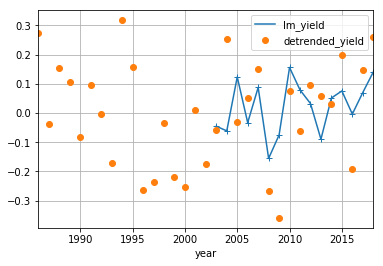

RMSE: 0.14790185559 R2: 0.262297736857

Wheat -- day of year: 95
Wheat_temp, 1-95
Wheat_ndvi_2ndcrop, 1-60
Wheat_rain_2ndcrop, 1-60
Wheat_et_2ndcrop, 1-60


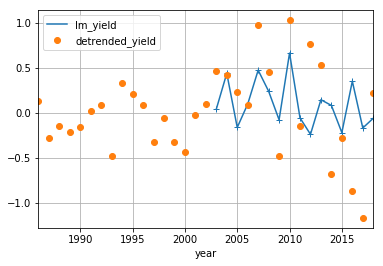

RMSE: 0.574298757865 R2: 0.172921861529

Barley -- day of year: 95
Barley_temp, 1-95
Barley_ndvi_2ndcrop, 1-60
Barley_rain_2ndcrop, 1-60
Barley_et_2ndcrop, 1-60


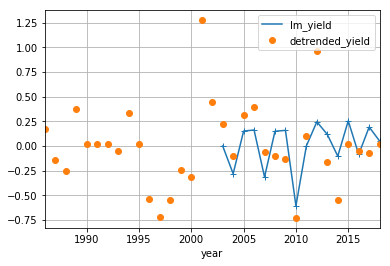

RMSE: 0.285383390198 R2: 0.390648059732

Sorghum -- day of year: 95
Sorghum_temp, 1-95
Sorghum_ndvi_2ndcrop, 1-60
Sorghum_rain_2ndcrop, 1-60
Sorghum_et_2ndcrop, 1-60


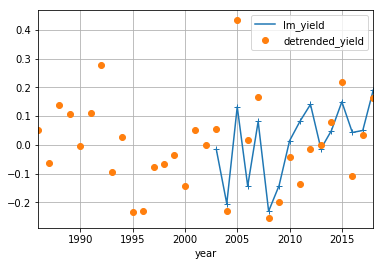

RMSE: 0.12201791611 R2: 0.512890872791

Millet -- day of year: 95
Millet_temp, 1-95
Millet_ndvi_2ndcrop, 1-60
Millet_rain_2ndcrop, 1-60
Millet_et_2ndcrop, 1-60


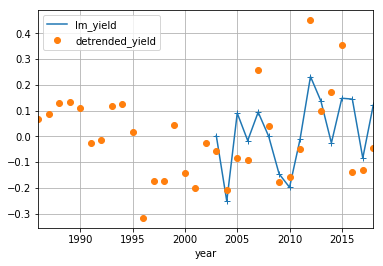

RMSE: 0.140571070479 R2: 0.465579440049



In [135]:
for crop in crops:
    train_model(95, crop)

Corn -- day of year: 273
Corn_temp, 1-273
Corn_ndvi_1stcrop, 112-273
Corn_rain_1stcrop, 112-273
Corn_et_1stcrop, 112-273
Corn_ndvi_2ndcrop, 1-60
Corn_rain_2ndcrop, 1-60
Corn_et_2ndcrop, 1-60


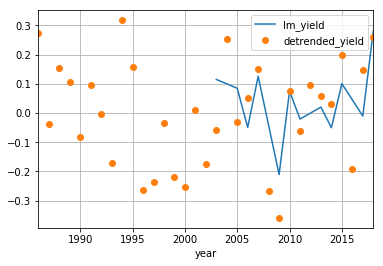

RMSE: 0.100013581202 R2: 0.576433294117

Wheat -- day of year: 273
Wheat_temp, 1-273
Wheat_ndvi_1stcrop, 112-273
Wheat_rain_1stcrop, 112-273
Wheat_et_1stcrop, 112-273
Wheat_ndvi_2ndcrop, 1-60
Wheat_rain_2ndcrop, 1-60
Wheat_et_2ndcrop, 1-60


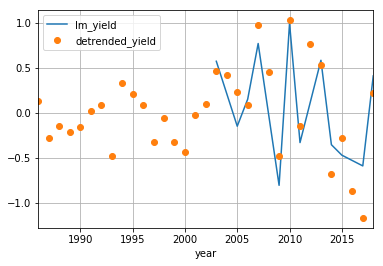

RMSE: 0.268904672689 R2: 0.817167804909

Barley -- day of year: 273
Barley_temp, 1-273
Barley_ndvi_1stcrop, 112-273
Barley_rain_1stcrop, 112-273
Barley_et_1stcrop, 112-273
Barley_ndvi_2ndcrop, 1-60
Barley_rain_2ndcrop, 1-60
Barley_et_2ndcrop, 1-60


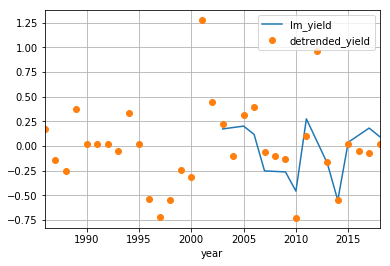

RMSE: 0.161823034662 R2: 0.729252295329

Sorghum -- day of year: 273
Sorghum_temp, 1-273
Sorghum_ndvi_1stcrop, 112-273
Sorghum_rain_1stcrop, 112-273
Sorghum_et_1stcrop, 112-273
Sorghum_ndvi_2ndcrop, 1-60
Sorghum_rain_2ndcrop, 1-60
Sorghum_et_2ndcrop, 1-60


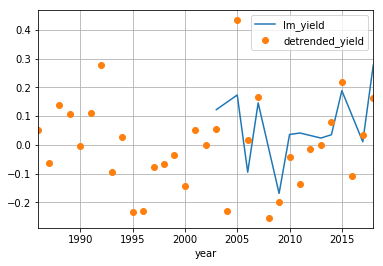

RMSE: 0.108076986126 R2: 0.547331678732

Millet -- day of year: 273
Millet_temp, 1-273
Millet_ndvi_1stcrop, 112-273
Millet_rain_1stcrop, 112-273
Millet_et_1stcrop, 112-273
Millet_ndvi_2ndcrop, 1-60
Millet_rain_2ndcrop, 1-60
Millet_et_2ndcrop, 1-60


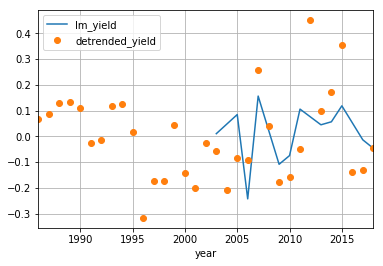

RMSE: 0.125001019848 R2: 0.427632869182



In [56]:
for crop in crops:
    train_model(273, crop)

Corn -- day of year: 182
Corn_temp, 1-182
Corn_ndvi_1stcrop, 112-182
Corn_rain_1stcrop, 112-182
Corn_et_1stcrop, 112-182
Corn_ndvi_2ndcrop, 1-60
Corn_rain_2ndcrop, 1-60
Corn_et_2ndcrop, 1-60


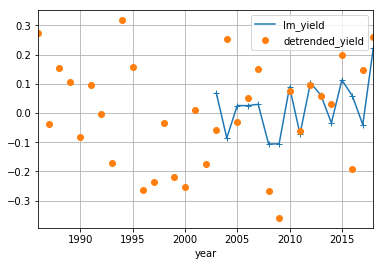

RMSE: 0.14793087698 R2: 0.262008203699

Wheat -- day of year: 182
Wheat_temp, 1-182
Wheat_ndvi_1stcrop, 112-182
Wheat_rain_1stcrop, 112-182
Wheat_et_1stcrop, 112-182
Wheat_ndvi_2ndcrop, 1-60
Wheat_rain_2ndcrop, 1-60
Wheat_et_2ndcrop, 1-60


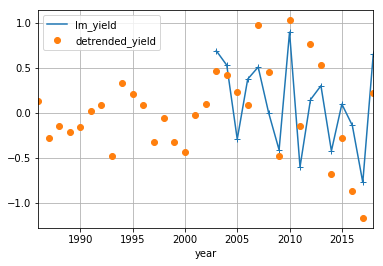

RMSE: 0.403755869706 R2: 0.591202260363

Barley -- day of year: 182
Barley_temp, 1-182
Barley_ndvi_1stcrop, 112-182
Barley_rain_1stcrop, 112-182
Barley_et_1stcrop, 112-182
Barley_ndvi_2ndcrop, 1-60
Barley_et_2ndcrop, 1-60


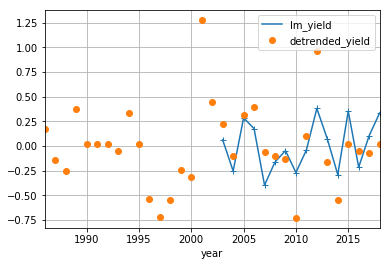

RMSE: 0.270777738437 R2: 0.451424097891

Sorghum -- day of year: 182
Sorghum_temp, 1-182
Sorghum_ndvi_1stcrop, 112-182
Sorghum_rain_1stcrop, 112-182
Sorghum_et_1stcrop, 112-182
Sorghum_ndvi_2ndcrop, 1-60
Sorghum_rain_2ndcrop, 1-60
Sorghum_et_2ndcrop, 1-60


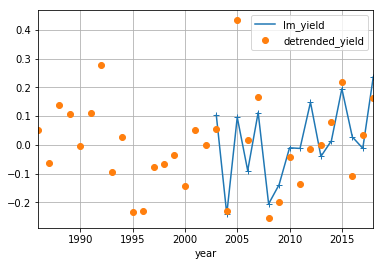

RMSE: 0.115137158927 R2: 0.566279372287

Millet -- day of year: 182
Millet_temp, 1-182
Millet_ndvi_1stcrop, 112-182
Millet_rain_1stcrop, 112-182
Millet_et_1stcrop, 112-182
Millet_ndvi_2ndcrop, 1-60
Millet_rain_2ndcrop, 1-60
Millet_et_2ndcrop, 1-60


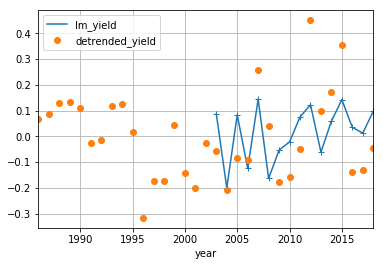

RMSE: 0.161091357791 R2: 0.29816384401



In [74]:
for crop in crops:
    train_model(182, crop)

# Performance Summary

In-sample fit statistics

In [136]:
header = 'Day of year'
for doy in sorted(lms_by_doy.keys()):
    header += '\t{}\t'.format(doy)
print(header +'\n------')
df = model.get_df()

for item_id, XY in df.loc[df.metric_id == yield_metric_id].groupby(['item_id']):
    crop = model.lookup('items', item_id)['name']
    row='{:8}'.format(crop)
    for lm in [lms_by_doy[doy].get(crop,(None,numpy.nan,numpy.nan)) for doy in sorted(lms_by_doy.keys())]:
        row += '\t{:4.1f}%\t{:4.1f}%|'.format(100*lm[1]/XY.value.mean(),100*lm[2])
    print(row)

Day of year	95		100		182		273	
------
Barley  	14.3%	39.1%|	15.5%	28.6%|	13.6%	45.1%|	 8.1%	72.9%|
Millet  	15.3%	46.6%|	18.3%	24.0%|	17.6%	29.8%|	13.6%	42.8%|
Wheat   	31.9%	17.3%|	32.1%	16.6%|	22.4%	59.1%|	14.9%	81.7%|
Corn    	 9.7%	26.2%|	10.7%	11.0%|	 9.7%	26.2%|	 6.6%	57.6%|
Sorghum 	14.1%	51.3%|	14.6%	47.9%|	13.3%	56.6%|	12.5%	54.7%|


# Forecast for 2020

In [137]:
def predict(crop, DOY, YEAR):
    print(crop)
    X = get_feature(cw_temp_dfs[crop], 'temp', doy=DOY, start_doy=1, year=YEAR)
    features = [
        get_feature(cw_ndvi_dfs[crop], 'ndvi1', 
                    doy=min(DOY - DOY%8, END_1), start_doy=START_1, tol=6, func=peak_day, year=YEAR), 
        get_feature(cw_rf_dfs[crop], 'rain1', 
                    doy=min(DOY, END_1), start_doy=START_1, year=YEAR), 
        get_feature(cw_eta_dfs[crop], 'et1', 
                    doy=min(DOY, END_1), tol=27, start_doy=START_1, year=YEAR), 
        get_feature(cw_ndvi_dfs[crop], 'ndvi2',
                    doy=min(DOY, END_2), start_doy=START_2,func=peak_day, tol=6, year=YEAR), 
        get_feature(cw_rf_dfs[crop], 'rain2',
                    doy=min(DOY, END_2), start_doy=START_2, year=YEAR), 
        get_feature(cw_eta_dfs[crop], 'et2',
                    doy=min(DOY,END_2), start_doy=START_2,year=YEAR, tol=27),
               ]
    for feature in filter(lambda f: not f.empty, features):
        X = X.merge(feature, on='year')
    feature_names = list(filter(lambda n: n not in ('year'), X.columns))
    lm_yield = lms_by_doy[DOY][crop][0].predict(X.loc[X.year == YEAR, feature_names])[0]
    if crop == 'Small millet':
        trend_yield = trends['Millet'].predict([[YEAR]])[0]
    else:
        trend_yield = trends[crop].predict([[YEAR]])[0]
    print('{:.2f} + {:.2f} = {:.2f} +/- {:.2f} t/ha\n'.format(
        lm_yield, trend_yield, lm_yield + trend_yield, lms_by_doy[DOY][crop][1]/2.0))

for crop in crops:
    predict(crop=crop, DOY=95, YEAR=2020)

Corn
temp, 1-95
ndvi2, 1-60
rain2, 1-60
et2, 1-60
0.23 + 1.60 = 1.83 +/- 0.07 t/ha

Wheat
temp, 1-95
ndvi2, 1-60
rain2, 1-60
et2, 1-60
0.61 + 2.35 = 2.96 +/- 0.29 t/ha

Barley
temp, 1-95
ndvi2, 1-60
rain2, 1-60
et2, 1-60
-0.63 + 4.03 = 3.40 +/- 0.14 t/ha

Sorghum
temp, 1-95
ndvi2, 1-60
rain2, 1-60
et2, 1-60
0.08 + 0.73 = 0.81 +/- 0.06 t/ha

Millet
temp, 1-95
ndvi2, 1-60
rain2, 1-60
et2, 1-60
-0.29 + 0.78 = 0.49 +/- 0.07 t/ha



In [138]:
model.get_df().shape

(4724352, 13)

In [139]:
import pickle
with open('kenya_cereals.data', 'wb') as dump_file:
    pickle.dump(model.get_df(), dump_file)